# xgboostを用いて、スプライスされやすい領域とそうでない領域の配列の学習を行う

**目的:**<br>
スプライシングを受けやすいイントロン領域とそうではないイントロン領域の二群に分割する<br>
各イントロンの両側n塩基の塩基配列を取得し、学習データとする<br>
教師あり学習であるXGBoostアルゴリズムを用いて、この二群のを分離させるような特徴的な塩基配列部位を同定する<br>
<br>

**略語**<br>
HAVSR: highly variable alternatively spliced<br>
LAVSR: Lowly variable alternatively spliced<br><br>

**注意点:**<br>
XGBClassifierのインスタンスおよびtrain_test_split関数のrandom stateを変更すると結果が異なる


## 準備

In [1]:
# オリジナルモジュールのインポート
from lib.introngap import PileUp
from lib.gbkparse import Seq_count

# モジュールのインポート
import itertools
import logomaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# クラスのインスタンス化
gbk = Seq_count()

# gbkファイルの読み込み
gbk.read_gbk('../data/gbk/human_ttn.gb')

デフォルト値として、最もエクソンの多いNM_001267550.2を設定


# 各イントロンの両端n塩基を抽出し下記の条件でデータを分割する
スプライシングを受けやすい領域(highs): intron 120-220<br>
スプライシングを受けにくい領域(lows): intron 221-

**変数の設定**

In [3]:
# 領域の指定
high_s, high_e = 120, 220
low_s, low_e = 0, 45
# low_s, low_e = 50, 90
# low_s, low_e = 221, gbk.intron_num()

# 各イントロンの両端n塩基を抽出し
n = 25

# XGBoostに関する変数の設定
early_stopping_rounds = 10
learning_rate = 0.01
max_depth = 8
x_random_state = 1
s_random_state =  0
test_size = 0.2


**学習データの取得**

In [4]:

# 各イントロンの5-prime側のn塩基を抽出 
left_edges = []
for i in range(gbk.intron_num()):
    left_edges.append(str(gbk.intron_seq(i+1)[:n]))

# 各イントロンの3-prime側のn塩基を抽出
right_edges = []
for i in range(gbk.intron_num()):
    right_edges.append(str(gbk.intron_seq(i+1)[-n:]))

## 各イントロンの5-prime側のn塩基にフォーカスし解析

In [5]:
# ラベルに使うイントロンの指定
left_edges_high = left_edges[high_s:high_e]
left_edges_low = left_edges[low_s:low_e] 

# ワンホットエンコーディングを行う関数
def one_hot_encode(seq):
    mapping = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    return np.array([mapping[s] for s in seq]).flatten()

# エンコーディングされた配列を準備
encoded_sequences_high_l = np.array([one_hot_encode(seq) for seq in left_edges_high])
encoded_sequences_low_l = np.array([one_hot_encode(seq) for seq in left_edges_low])

In [6]:
# 学習データとしてワンホとエンコーディングされた配列を結合しXとする
# ラベルをyとして結合する
X = pd.DataFrame(np.concatenate([encoded_sequences_high_l, encoded_sequences_low_l]))
y = pd.DataFrame(np.concatenate([np.ones(len(encoded_sequences_high_l)), np.zeros(len(encoded_sequences_low_l))]))

# XGBoostのインスタンス化
model_l = XGBClassifier(early_stopping_rounds=early_stopping_rounds, learning_rate=learning_rate, max_depth=max_depth, random_state=x_random_state)

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=s_random_state)

# データをモデルにfitさせる
eval_set = [(X_test, y_test)]
model_l.fit(X_train, y_train, eval_set=eval_set, verbose=False)    

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

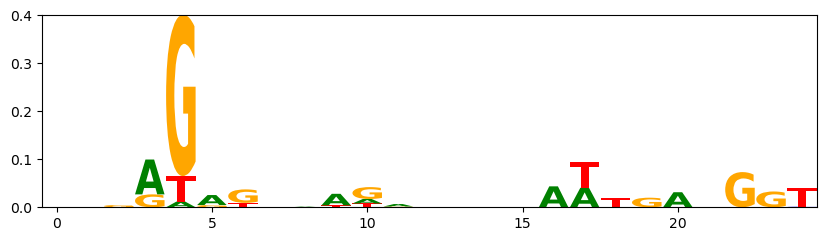

In [7]:
# logomakerを用いてモチーフを可視化
b_df_l = pd.DataFrame(model_l.feature_importances_.reshape(n,4))
b_df_l.columns = ['A','T','G','C']
crp_logo = logomaker.Logo(b_df_l, shade_below=.5, fade_below=.5)

In [8]:
pos = 4
base = "G"

count = 0
for i in left_edges_high:
    if i[pos] == base:
        count += 1
print("high:",count/len(left_edges_high))

count = 0
for i in left_edges_low:
    if i[pos] == base:
        count += 1
print("low:",count/len(left_edges_low))

high: 0.11
low: 0.6444444444444445


## 各イントロンの3-prime側のn塩基にフォーカスし解析

In [9]:
# ラベルに使うイントロンの指定
right_edges_high = right_edges[high_s:high_e]
right_edges_low = right_edges[low_s:low_e] 

# ワンホットエンコーディングを行う関数
def one_hot_encode(seq):
    mapping = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    return np.array([mapping[s] for s in seq]).flatten()

# エンコーディングされた配列を準備
encoded_sequences_high_r = np.array([one_hot_encode(seq) for seq in right_edges_high])
encoded_sequences_low_r = np.array([one_hot_encode(seq) for seq in right_edges_low])

In [10]:
# 学習データとしてワンホとエンコーディングされた配列を結合しXとする
# ラベルをyとして結合する
X = pd.DataFrame(np.concatenate([encoded_sequences_high_r, encoded_sequences_low_r]))
y = pd.DataFrame(np.concatenate([np.ones(len(encoded_sequences_high_r)), np.zeros(len(encoded_sequences_low_r))]))

# XGBoostのインスタンス化
model_r = XGBClassifier(early_stopping_rounds=early_stopping_rounds, learning_rate=learning_rate, max_depth=max_depth, random_state=x_random_state)

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=s_random_state)

# データをモデルにfitさせる
eval_set = [(X_test, y_test)]
model_r.fit(X_train, y_train, eval_set=eval_set, verbose=False)    

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

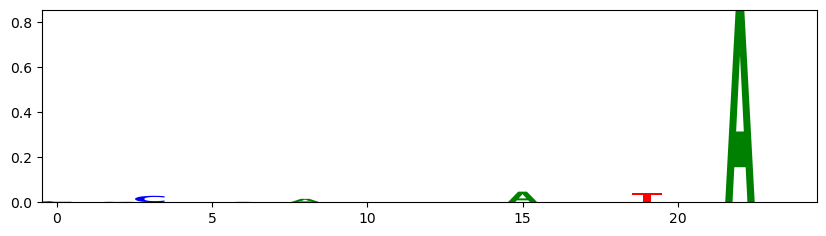

In [11]:
# logomakerを用いてモチーフを可視化
b_df_r = pd.DataFrame(model_r.feature_importances_.reshape(n,4))
b_df_r.columns = ['A','T','G','C']
crp_logo = logomaker.Logo(b_df_r, shade_below=.5, fade_below=.5)

In [12]:
pos = -3
base = "A"

count = 0
for i in right_edges_high:
    # print(i)
    if i[pos] == base:
        count += 1
print("high:", count/len(right_edges_high))

count = 0
for i in right_edges_low:
    # print(i)
    if i[pos] == base:
        count += 1
print("low:", count/len(right_edges_low))

high: 0.96
low: 0.06666666666666667


## HVASとLVAS領域のイントロン両端の塩基配列のパターンを可視化
それぞれの領域に含まれるイントロンの両端を揃え、塩基の出現頻度をヒートマップ化

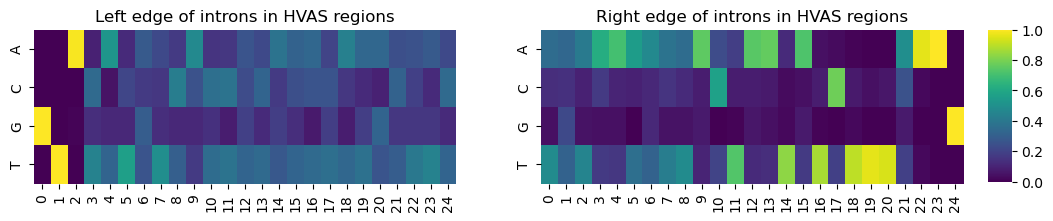

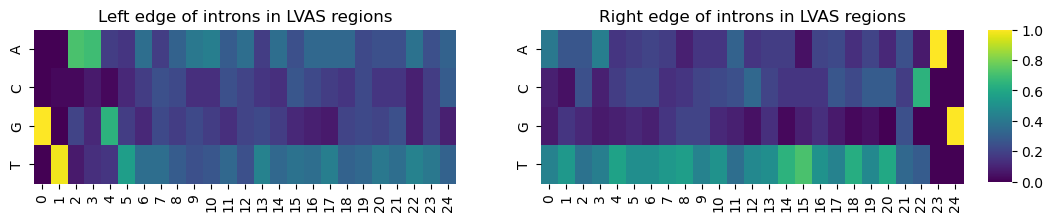

In [13]:
vmin, vmax = 0, 1

# ヒートマップの描画
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 2))

# 最初のヒートマップ
l_df = pd.DataFrame([list(i) for i in left_edges_high])
sns.heatmap(l_df.apply(pd.Series.value_counts).fillna(0).astype(int)/len(left_edges_high), ax=ax1, cmap="viridis", vmin=vmin, vmax=vmax, cbar=False)
ax1.set_title("Left edge of introns in HVAS regions")

# 2つ目のヒートマップ
r_df = pd.DataFrame([list(i) for i in right_edges_high])
cax = fig.add_axes([0.92, 0.12, 0.02, 0.76])  # カラーバーの位置とサイズを調整
sns.heatmap(r_df.apply(pd.Series.value_counts).fillna(0).astype(int)/len(right_edges_high), ax=ax2, cmap="viridis",vmin=vmin, vmax=vmax, cbar_ax=cax)
ax2.set_title("Right edge of introns in HVAS regions")

# Figureの表示
fig.show()

# ヒートマップの描画
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 2))

# 最初のヒートマップ
l_df = pd.DataFrame([list(i) for i in left_edges_low])
sns.heatmap(l_df.apply(pd.Series.value_counts).fillna(0).astype(int)/len(left_edges_low), ax=ax1, cmap="viridis", vmin=vmin, vmax=vmax, cbar=False)
ax1.set_title("Left edge of introns in LVAS regions")

# 2つ目のヒートマップ
r_df = pd.DataFrame([list(i) for i in right_edges_low])
cax = fig.add_axes([0.92, 0.12, 0.02, 0.76])  # カラーバーの位置とサイズを調整
sns.heatmap(r_df.apply(pd.Series.value_counts).fillna(0).astype(int)/len(right_edges_low), ax=ax2, cmap="viridis", vmin=vmin, vmax=vmax, cbar_ax=cax)
ax2.set_title("Right edge of introns in LVAS regions")

# Figureの表示
fig.show()